# Data exploration

Goal - create ML model for prediction points target variable in range 0 - 100 based on input data in wine reviews dataset.

First we need to load dataset and make further steps:
   - Check data types of columns
   - Check existance of null values
   - Plot distributions
   - Check correlations between target variable and input features
   - Check correlations between input features
  
Hypotheses:
   - Wines with higher prices are highly rated with more points
   - Some wine varieties will get more points than others
   - Wines from some countries will get more points than from others
   - Description is highly related with given score (points)

In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

### Check data types of columns and determine category of features (variables)
For data exploration analysis we will use just winemag-data-130k-v2.csv dataset. In training model stage we will use both datasets with dropping duplicate values.

In [3]:
df = pd.read_csv("data/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


There is a lot of information about countries, province and regions in dataset. This informations will be better replace with for wine growth significant informations like weather conditions etc... With this type of informations we will be able to categorise data and conclude what are the best conditions for specific wine variety.

In [4]:
df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

From previous insights we can categorise features. 
- country               - nominal
- description           - text
- designation           - nominal
- points                - continuous	
- price	                - continuous    
- province	            - nominal
- region_1	            - nominal
- region_2	            - nominal
- taster_name           - nominal	
- taster_twitter_handle - nominal
- title	                - text
- variety	            - nominal
- winery                - nominal

In [5]:
df_missing = df.isnull().sum()
df_missing

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [6]:
df.shape[0]

129971

#### Calculate procentage of missign values per feature
Accetable features has less than 20% of missing values.

In [7]:
def miss_percentage(df):
    """
    Calculate missing value percentage per dataset features (columns in dataframe).
    :param df: input pandas dataframe with missing values
    :return:   pandas dataframe, index = column names, columns = [missing values percentage, missing count]
    """
    df_missing = df.isnull().sum().reset_index()
    df_missing.columns = ['features', 'missing_counts']
    df_len = df.shape[0]
    df_missing['missing_percentage'] = df_missing['missing_counts'].apply(lambda v: v/df_len)

    return df_missing.sort_values(by='missing_percentage', ascending=False).set_index(keys='features')

df_miss_info = miss_percentage(df)
df_miss_info   
    

,missing_counts,missing_percentage
features,,
region_2,79460,0.611367
designation,37465,0.288257
taster_twitter_handle,31213,0.240154
taster_name,26244,0.201922
region_1,21247,0.163475
price,8996,0.069215
country,63,0.000485
province,63,0.000485
variety,1,0.000008


In [8]:
df[['region_2']].value_counts().shape[0]

17

In [9]:
def get_unique_values_per_feature(df, column_names):
    """
    Calculate missing value percentage per dataset features (columns in dataframe).
    :param df: input pandas dataframe with missing values
    :param column_names: names of interesting columns
    :return:   python dict, keys = column names, values = unique values
    """
    unique_fea_dict = {}
    
    for col in column_names:
        df_unique = df[[col]].value_counts().shape[0]
        unique_fea_dict[col] = df_unique

    #pd.DataFrame.from_dict(unique_fea_dict)
    return unique_fea_dict

column_names = ['region_2', 'designation', 'taster_twitter_handle', 'taster_name']
df_unique = get_unique_values_per_feature(df, column_names)
print(df_unique)

{'region_2': 17, 'designation': 37979, 'taster_twitter_handle': 15, 'taster_name': 19}


Designation will be excluded from further analysis. Designation feature is nominal. Nominal features can be imputed by most frequent value, with aditional category ('missing') or predicted by ML model. The problem for mentioned imputation methods are a lot of unique values. Another reason is that information contained in designation is also present in textual feature title.
Region_2 feature has more than 60% of missing values so it's obvious that need to be droped.

In [10]:
df[['taster_twitter_handle', 'taster_name']]

,taster_twitter_handle,taster_name
0,@kerinokeefe,Kerin O’Keefe
1,@vossroger,Roger Voss
2,@paulgwine,Paul Gregutt
3,NaN,Alexander Peartree
4,@paulgwine,Paul Gregutt
...,...,...
129966,NaN,Anna Lee C. Iijima
129967,@paulgwine,Paul Gregutt
129968,@vossroger,Roger Voss
129969,@vossroger,Roger Voss


taster_twitter_handle is redudant information because it's contained in taster_name and worth to mention that taster_twitter_handle has more missing and less unique values than tester_name feature.

Before look in distributions we need to impute missing values. Just for visualization and statistics purposes missing values will be replaced with 'Missing' string.

In [11]:
df = df.drop(['designation', 'taster_twitter_handle', 'region_2'], axis=1)
df.head()

,country,description,points,price,province,region_1,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Drop one sample with missing variety value. One sample can't be statistically significant.

In [12]:
df[['variety']].isnull().sum()

variety    1
dtype: int64

In [13]:
df = df[df.variety.notna()].reset_index()
df = df.drop('index', axis=1)
df.head()

,country,description,points,price,province,region_1,taster_name,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Feature correlation

#### Countinuous features distributions

<AxesSubplot:xlabel='points'>

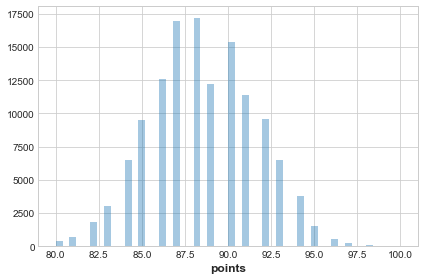

In [14]:
# Histogram 
sns.distplot(a=df['points'], kde=False)

<AxesSubplot:xlabel='points', ylabel='Density'>

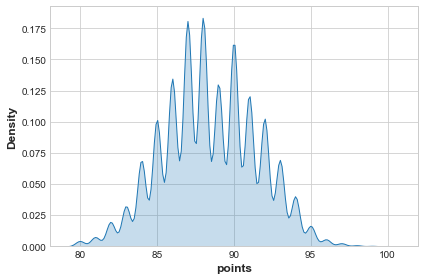

In [15]:
# KDE plot 
sns.kdeplot(data=df['points'], shade=True)

Points feature range in dataset is actually between 80 and 100. So, we can conclude that only best rated wines are in input dataset. Distribution is **aproximately** bell curved, with some missing points in between.

<AxesSubplot:xlabel='price'>

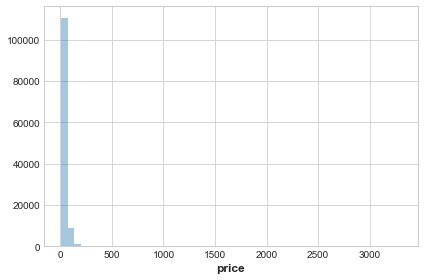

In [16]:
# Histogram 
sns.distplot(a=df['price'], kde=False)

On price distribution histogram if the range is from 0 to 3000 most of the wines are in range from 0 - 500. So probably more expensive wines are over rated and to expensive (outliers). So this outliers need to be removed.

In [17]:
df = df.loc[df['price'] <= 500]

<AxesSubplot:xlabel='price'>

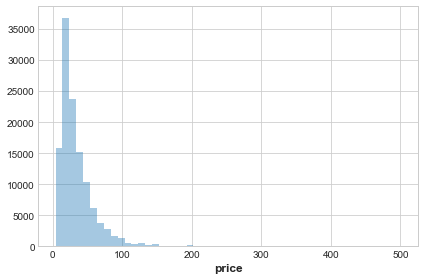

In [18]:
# Histogram 
sns.distplot(a=df['price'], kde=False)

<AxesSubplot:xlabel='price', ylabel='Density'>

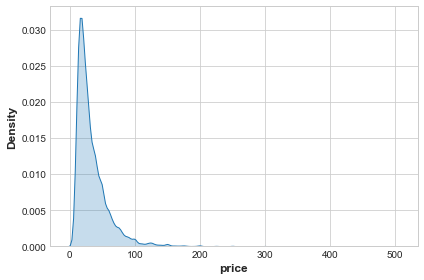

In [19]:
# KDE plot 
sns.kdeplot(data=df['price'], shade=True)


"In the study of probability theory, the **central limit theorem (CLT**) states that the distribution of sample approximates a normal distribution (also known as a “bell curve”) as the sample size becomes larger, assuming that all samples are identical in size, and regardless of the population distribution shape.

Said another way, CLT is a statistical theory stating that given a sufficiently large sample size from a population with a finite level of variance, the mean of all samples from the same population will be approximately equal to the mean of the population. "

Price distribution is right skewed so it need to be transformed in bell shaped curve in feature engineering step.
It is important for most ML models except decision tree based. 

If data distribution is bell shaped curve models will have better generalization.  

#### Points - price correlation

<AxesSubplot:xlabel='price', ylabel='points'>

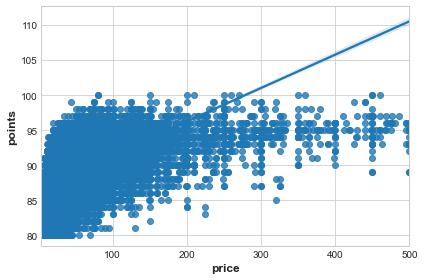

In [20]:
sns.regplot(x=df['price'], y=df['points'])

Linear correlation between price and points its not so obviuos. We see that both the lower and higher priced wines could have same points. Also worth to mention points-price function is not linear. There is a lot of variance (spread) in data.


### Statistics
The size of a correlation coefficient suggests correlation between independent and dependent variable.
p-value indicates significance of correlation coefficient (p-value <= 0.05).
We will use the following methods to calculate the correlation coefficients:
   - Pearson correlation coefficient - strength and direction of the linear relationship between two variables
   - Spearman correlation coefficient - Spearman's correlation determines the strength and direction of the monotonic relationship between two variables rather than the strength and direction of the linear relationship between two variables

In [21]:
import scipy as sc

stats_pe_spe = {"corr": [], "p-value": []}

pearson_price_points = sc.stats.pearsonr(df.price, df.points)
spearman_price_points = sc.stats.spearmanr(df.price, df.points)

for i in range(len(list(stats_pe_spe.keys()))):
    stats_pe_spe[list(stats_pe_spe.keys())[i]].append(pearson_price_points[i])
    stats_pe_spe[list(stats_pe_spe.keys())[i]].append(pearson_price_points[i])

pd.DataFrame(stats_pe_spe, columns=['corr', 'p-value'], index=['pearson', 'spearman'])

,corr,p-value
pearson,0.495518,0.0
spearman,0.495518,0.0


p-value near zero indicates significance of correlation coefficient but correlation coefficient need to be abs(corr) >= 0.5.
More siginificat relationship is between 0.7-1.


Price feature can be included in input dataset but it will not siginifantly influence on ML model accuracy in positive manner. Probably if price feature will be included in input dataset more noise will be added which will lead to lower accuracy of ML model. So price will be excluded from input dataset.

In [22]:
df = df.drop('price', axis=1)
df.head()

,country,description,points,province,region_1,taster_name,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


### Correlation between nominal and continuous features

We need to discover most common categories inside all features and plot distributions between them and target points variable.
Also mutual information between categorical and points target variables need to be calculated. 
See at documentation https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

#### Variety

In [23]:
df.variety.value_counts()

Pinot Noir                  12775
Chardonnay                  11064
Cabernet Sauvignon           9383
Red Blend                    8476
Bordeaux-style Red Blend     5325
                            ...  
Sauvignon-Sémillon              1
Grenache Gris                   1
Kuntra                          1
Pinot Blanc-Pinot Noir          1
Gelber Traminer                 1
Name: variety, Length: 697, dtype: int64

Wine varieties which has lower than 100 rewievs will be **removed in exploration analysis** because we want to have representative dataset.

In [24]:
df_variety = df.groupby('variety').filter(lambda df: len(df.variety) > 100)
df_variety.head()

,country,description,points,province,region_1,taster_name,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
7,France,This dry and restrained wine offers spice in p...,87,Alsace,Alsace,Roger Voss,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach


In [25]:
df_variety.variety.value_counts().shape[0]

88

Get number of reviews per variety category.

In [26]:
df_variety_len = df_variety.variety.value_counts()
df_variety_len = pd.DataFrame(df_variety_len).reset_index()
df_variety_len.columns = ['variety', 'num_of_reviews']
df_variety_len

,variety,num_of_reviews
0,Pinot Noir,12775
1,Chardonnay,11064
2,Cabernet Sauvignon,9383
3,Red Blend,8476
4,Bordeaux-style Red Blend,5325
...,...,...
83,Greco,111
84,Grillo,109
85,Viura,105
86,Bonarda,105


Take random ten categories from variety feature and plot distributions for target points variable.

[Text(0, 0, 'Pinot Noir'),
 Text(1, 0, 'Zinfandel'),
 Text(2, 0, 'Grüner Veltliner'),
 Text(3, 0, 'Viognier'),
 Text(4, 0, 'Nebbiolo'),
 Text(5, 0, 'Pinot Grigio'),
 Text(6, 0, 'Pinot Nero'),
 Text(7, 0, 'Corvina, Rondinella, Molinara'),
 Text(8, 0, 'Cabernet Sauvignon-Merlot'),
 Text(9, 0, 'Touriga Nacional')]

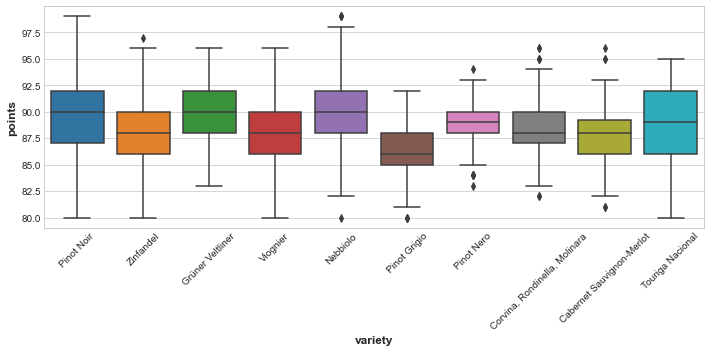

In [27]:
df_variety_len_rand = df_variety_len.sample(n=10)
df_variety_list = df_variety_len_rand.variety.tolist()
df_variety = df.loc[df.variety.isin(df_variety_list)]
plt.figure(figsize=(10,5))
chart = sns.boxplot(
    data=df_variety,
    x='variety',
    y="points",
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Because a lot of overlaping of target points variable distributions between different varieties we can say that variety feature is not highly corelated with points variable, but before we can decide to drop variety feature we will calculate mutual information between variety and points variables. Look at **Mutual information** section.

#### Country

Let's see countries with most reviews.

In [28]:
df_country_count = df.groupby('country').apply(lambda df: len(df))
df_country_count = df_country_count.reset_index()
df_country_count.columns = ['country', 'num_of_reviews']
df_country_count = df_country_count.sort_values(by=['num_of_reviews'], ascending=False)
df_country_count

,country,num_of_reviews
39,US,54260
14,France,17722
21,Italy,16905
36,Spain,6570
30,Portugal,4868
8,Chile,4415
0,Argentina,3756
3,Austria,2798
2,Australia,2290
16,Germany,2113


First 12 countries has much more reviews than others but we will select countries with more than 100 reviews just to get more variance of data.

In [29]:
df_country = df.groupby('country').filter(lambda df: len(df.country) > 100)
df_country.country.value_counts()

US              54260
France          17722
Italy           16905
Spain            6570
Portugal         4868
Chile            4415
Argentina        3756
Austria          2798
Australia        2290
Germany          2113
New Zealand      1378
South Africa     1293
Israel            489
Greece            461
Canada            254
Hungary           144
Bulgaria          141
Romania           120
Uruguay           109
Name: country, dtype: int64

Take ten random countries and plot distribution of points target variable based on that ten country categories.

[Text(0, 0, 'Portugal'),
 Text(1, 0, 'Spain'),
 Text(2, 0, 'France'),
 Text(3, 0, 'Germany'),
 Text(4, 0, 'Argentina'),
 Text(5, 0, 'South Africa'),
 Text(6, 0, 'Israel'),
 Text(7, 0, 'Hungary'),
 Text(8, 0, 'Canada'),
 Text(9, 0, 'Uruguay')]

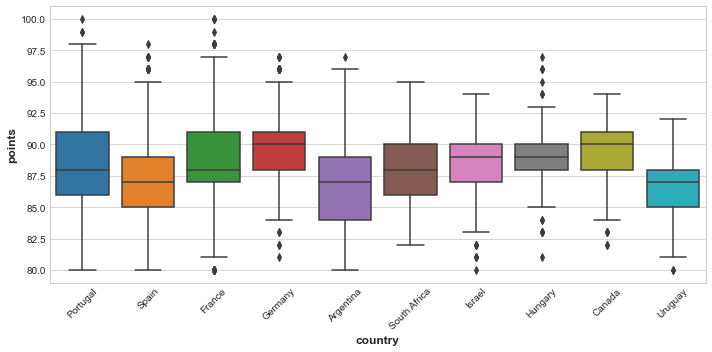

In [30]:
df_country_len = df_country.country.value_counts()
df_country_len = pd.DataFrame(df_country_len).reset_index()
df_country_len.columns = ['country', 'num_of_reviews']

df_country_count_rand = df_country_len.sample(n=10)
df_country_list = df_country_count_rand.country.tolist()
df_country = df_country.loc[df_country.country.isin(df_country_list)]
plt.figure(figsize=(10,5))
chart = sns.boxplot(
    data=df_country,
    x='country',
    y="points",
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Because a lot of overlaping of target points variable distributions between different countries we can say that country feature is not highly corelated with points variable, but before we can decide to drop country feature we will calculate mutual information between country and points variables. Look at **Mutual information** section.

#### Winery

Let's see wineries with most reviews.

In [31]:
df_winery_count = df.groupby('winery').apply(lambda df: len(df))
df_winery_count = df_winery_count.reset_index()
df_winery_count.columns = ['winery', 'num_of_reviews']
df_winery_count = df_winery_count.sort_values(by=['num_of_reviews'], ascending=False)
df_winery_count

,winery,num_of_reviews
14188,Testarossa,217
15575,Williams Selyem,211
5017,DFJ Vinhos,209
15622,Wines & Winemakers,209
2737,Chateau Ste. Michelle,193
...,...,...
3441,Château Lauzade,1
12758,Ryzin,1
12759,Régis Jouan,1
3436,Château Laujac,1


In [32]:
df.winery.value_counts()

Testarossa               217
Williams Selyem          211
Wines & Winemakers       209
DFJ Vinhos               209
Chateau Ste. Michelle    193
                        ... 
Royal de Jarras            1
Occam's Razor              1
District                   1
Stone Creek                1
Château Goumin             1
Name: winery, Length: 15850, dtype: int64

**First insight**

Like we can see winery feature have more than 15000 unique wineries which is more than 10% of length of samples.
Because it is nominal variable we have few options for encoding: a)create new numerical feature (CountFrequencyEncoder, and related encoders see docs: https://feature-engine.readthedocs.io/en/latest/encoding/CountFrequencyEncoder.html)     b) label encoding c) one-hot encoding

If we want to use this feature in input data for decision tree based algorithms label encoder will be more appropriate than one-hot encoding. For neural nets prefered way is to use one-hot encoding or one of the methods mentioned in section a). In one-hot encoding representation matrices will be very sparse which lead to a lot more new features and computational time will increase. The main effect will be that we will need more complex model which need to be properly regulized to not overfit. But still there can be solution in creating new feature from that one-hot encoded feature. From one-hot encoded feature we get 2D sparse matrix which can be multiplied with numerical feature to get new vector numerical feature. In this case we drop price feature because of low correlation with target wariable so this option is excluded. But for final decision we will calculate mutual information.

In [33]:
df_winery = df.groupby('winery').filter(lambda df: len(df.winery) > 100)
df_winery.winery.value_counts()

Testarossa               217
Williams Selyem          211
Wines & Winemakers       209
DFJ Vinhos               209
Chateau Ste. Michelle    193
Louis Latour             168
Concha y Toro            162
Columbia Crest           158
Kendall-Jackson          130
Siduri                   126
Gary Farrell             125
Georges Duboeuf          120
Lynmar                   118
Montes                   117
Trapiche                 112
Robert Mondavi           112
Undurraga                112
Santa Ema                111
Fess Parker              108
V. Sattui                107
Iron Horse               106
Foxen                    105
Maryhill                 102
Chehalem                 102
Kunde                    101
Name: winery, dtype: int64

[Text(0, 0, 'Louis Latour'),
 Text(1, 0, 'Undurraga'),
 Text(2, 0, 'Chehalem'),
 Text(3, 0, 'Chateau Ste. Michelle'),
 Text(4, 0, 'Wines & Winemakers'),
 Text(5, 0, 'Georges Duboeuf'),
 Text(6, 0, 'Kendall-Jackson'),
 Text(7, 0, 'Columbia Crest'),
 Text(8, 0, 'Montes'),
 Text(9, 0, 'Kunde')]

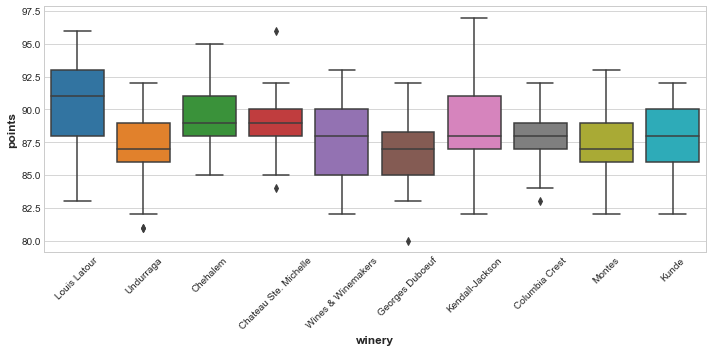

In [34]:
df_winery_len = df_winery.winery.value_counts()
df_winery_len = pd.DataFrame(df_winery_len).reset_index()
df_winery_len.columns = ['winery', 'num_of_reviews']

df_winery_count_rand = df_winery_len.sample(n=10)
df_winery_list = df_winery_count_rand.winery.tolist()
df_winery = df_winery.loc[df_winery.winery.isin(df_winery_list)]

plt.figure(figsize=(10,5))
chart = sns.boxplot(
    data=df_winery,
    x='winery',
    y="points",
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Based on the ploted distributions we can see less overlap and higher difference of median values for different categories. The difference is higher because of less data assigned to each category (we need to be cautious). 

#### Province

Let's see provinces with most reviews.

In [35]:
df_province_count = df.groupby('province').apply(lambda df: len(df))
df_province_count = df_province_count.reset_index()
df_province_count.columns = ['province', 'num_of_reviews']
df_province_count = df_province_count.sort_values(by=['num_of_reviews'], ascending=False)
df_province_count

,province,num_of_reviews
51,California,36099
408,Washington,8583
266,Oregon,5359
371,Tuscany,5121
36,Bordeaux,3978
...,...,...
198,Lutzville Valley,1
102,Dealurile Hușilor,1
269,Paardeberg,1
351,Table wine,1


In [36]:
df_province = df.groupby('province').filter(lambda df: len(df.province) > 1000)
df_province.province.value_counts()

California            36099
Washington             8583
Oregon                 5359
Tuscany                5121
Bordeaux               3978
Northern Spain         3795
Mendoza Province       3226
Piedmont               3088
Burgundy               3083
New York               2676
Veneto                 2314
Alsace                 2147
Northeastern Italy     1986
Loire Valley           1597
Sicily & Sardinia      1559
Champagne              1377
Southwest France       1335
South Australia        1327
Catalonia              1152
Provence               1139
Douro                  1134
Southern Italy         1131
Central Italy          1100
Rhône Valley           1042
Mosel                  1023
Name: province, dtype: int64

[Text(0, 0, 'Oregon'),
 Text(1, 0, 'Sicily & Sardinia'),
 Text(2, 0, 'Mosel'),
 Text(3, 0, 'Washington'),
 Text(4, 0, 'Central Italy'),
 Text(5, 0, 'Champagne'),
 Text(6, 0, 'Burgundy'),
 Text(7, 0, 'New York'),
 Text(8, 0, 'Piedmont'),
 Text(9, 0, 'Northeastern Italy')]

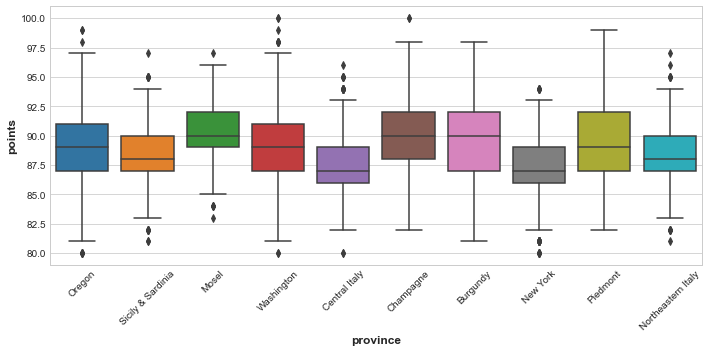

In [37]:
df_province_len = df_province.province.value_counts()
df_province_len = pd.DataFrame(df_province_len).reset_index()
df_province_len.columns = ['province', 'num_of_reviews']

df_province_count_rand = df_province_len.sample(n=10)
df_province_list = df_province_count_rand.province.tolist()
df_province = df_province.loc[df_province.province.isin(df_province_list)]

plt.figure(figsize=(10,5))
chart = sns.boxplot(
    data=df_province,
    x='province',
    y="points",
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Because a lot of overlaping of target points variable distributions between different provinces we can say that province feature is not highly corelated with points variable, but before we can decide to drop province feature we will calculate mutual information between province and points variables. Look at **Mutual information** section.

#### Region_1

Let's see regions with most reviews.

In [38]:
df_region_1_count = df.groupby('region_1').apply(lambda df: len(df))
df_region_1_count = df_region_1_count.reset_index()
df_region_1_count.columns = ['region_1', 'num_of_reviews']
df_region_1_count = df_region_1_count.sort_values(by=['num_of_reviews'], ascending=False)
df_region_1_count

,region_1,num_of_reviews
727,Napa Valley,4472
277,Columbia Valley (WA),4109
889,Russian River Valley,3090
152,California,2627
778,Paso Robles,2326
...,...,...
1046,Texoma,1
464,Geographe,1
463,Geelong,1
878,Rosso di Cerignola,1


In [39]:
df_region_1 = df.groupby('region_1').filter(lambda df: len(df.region_1) > 1000)
df_region_1.region_1.value_counts()

Napa Valley                4472
Columbia Valley (WA)       4109
Russian River Valley       3090
California                 2627
Paso Robles                2326
Willamette Valley          2296
Mendoza                    2275
Alsace                     1897
Finger Lakes               1556
Sonoma Coast               1467
Rioja                      1453
Champagne                  1377
Barolo                     1359
Sonoma County              1245
Brunello di Montalcino     1206
Toscana                    1077
Walla Walla Valley (WA)    1061
Name: region_1, dtype: int64

[Text(0, 0, 'Mendoza'),
 Text(1, 0, 'Paso Robles'),
 Text(2, 0, 'Sonoma Coast'),
 Text(3, 0, 'California'),
 Text(4, 0, 'Toscana'),
 Text(5, 0, 'Sonoma County'),
 Text(6, 0, 'Barolo'),
 Text(7, 0, 'Russian River Valley'),
 Text(8, 0, 'Walla Walla Valley (WA)'),
 Text(9, 0, 'Rioja')]

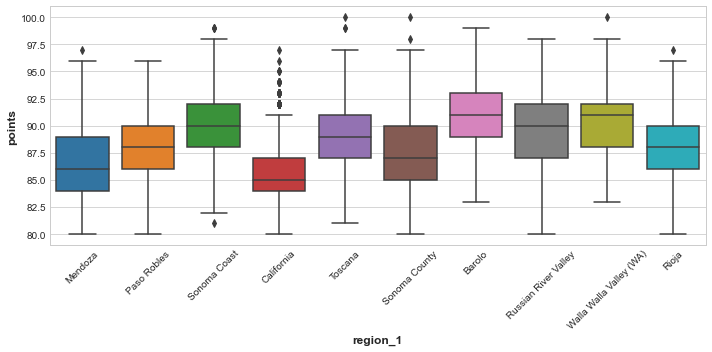

In [40]:
df_region_1_len = df_region_1.region_1.value_counts()
df_region_1_len = pd.DataFrame(df_region_1_len).reset_index()
df_region_1_len.columns = ['region_1', 'num_of_reviews']

df_region_1_count_rand = df_region_1_len.sample(n=10)
df_region_1_list = df_region_1_count_rand.region_1.tolist()
df_region_1 = df_region_1.loc[df_region_1.region_1.isin(df_region_1_list)]

plt.figure(figsize=(10,5))
chart = sns.boxplot(
    data=df_region_1,
    x='region_1',
    y="points",
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Because a lot of overlaping of target points variable distributions between different regions we can say that region_1 feature is not highly corelated with points variable, but before we can decide to drop region_1 feature we will calculate mutual information between region_1 and points variables. Look at **Mutual information** section.

#### Taster name

Let's see tasters with most given reviews.

In [41]:
df.head()

,country,description,points,province,region_1,taster_name,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


In [42]:
df_taster_count = df.groupby('taster_name').apply(lambda df: len(df))
df_taster_count = df_taster_count.reset_index()
df_taster_count.columns = ['taster_name', 'num_of_reviews']
df_taster_count = df_taster_count.sort_values(by=['num_of_reviews'], ascending=False)
df_taster_count

,taster_name,num_of_reviews
15,Roger Voss,20111
12,Michael Schachner,14948
9,Kerin O’Keefe,9867
18,Virginie Boone,9506
14,Paul Gregutt,9498
11,Matt Kettmann,6235
8,Joe Czerwinski,5007
16,Sean P. Sullivan,4925
1,Anna Lee C. Iijima,4362
7,Jim Gordon,4171


In [43]:
df_taster_name = df.groupby('taster_name').filter(lambda df: len(df.taster_name) > 1000)
df_taster_name.taster_name.value_counts()

Roger Voss            20111
Michael Schachner     14948
Kerin O’Keefe          9867
Virginie Boone         9506
Paul Gregutt           9498
Matt Kettmann          6235
Joe Czerwinski         5007
Sean P. Sullivan       4925
Anna Lee C. Iijima     4362
Jim Gordon             4171
Anne Krebiehl MW       3397
Lauren Buzzeo          1713
Susan Kostrzewa        1073
Name: taster_name, dtype: int64

[Text(0, 0, 'Roger Voss'),
 Text(1, 0, 'Michael Schachner'),
 Text(2, 0, 'Kerin O’Keefe'),
 Text(3, 0, 'Virginie Boone'),
 Text(4, 0, 'Matt Kettmann'),
 Text(5, 0, 'Sean P. Sullivan'),
 Text(6, 0, 'Jim Gordon'),
 Text(7, 0, 'Joe Czerwinski'),
 Text(8, 0, 'Lauren Buzzeo'),
 Text(9, 0, 'Susan Kostrzewa')]

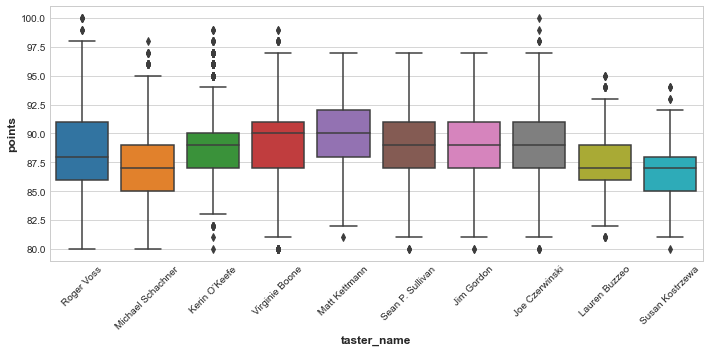

In [44]:
df_taster_len = df_taster_name.taster_name.value_counts()
df_taster_len = pd.DataFrame(df_taster_len).reset_index()
df_taster_len.columns = ['taster_name', 'num_of_reviews']

df_taster_name_count_rand = df_taster_len.sample(n=10)
df_taster_name_list = df_taster_name_count_rand.taster_name.tolist()
df_taster_name = df_taster_name.loc[df_taster_name.taster_name.isin(df_taster_name_list)]

plt.figure(figsize=(10,5))
chart = sns.boxplot(
    data=df_taster_name,
    x='taster_name',
    y="points",
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Because a lot of overlaping of target points variable distributions between given tasters we can say that taster_name feature is not highly corelated with points variable, but before we can decide to drop taster_name feature we will calculate mutual information between taster_name and points variables. Look at **Mutual information** section.

### Mutual information
Docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

Before calculating mutual information between features and target variable all feature need to be encoded and missing values need to be filled. Just for mutual information analysis we will fill categorical variables with new category 'Missing'.

In [45]:
df.dtypes

country        object
description    object
points          int64
province       object
region_1       object
taster_name    object
title          object
variety        object
winery         object
dtype: object

In [46]:
def impute(df):
    """
    Fill categorical variables with new category 'Missing'.
    param df:           input pandas dataframe
    return df_not_none: pandas dataframe with filled missing values for categorical variables
    """
    df_not_none = df.copy()
    for name in df.select_dtypes("object"):
        df_not_none[name] = df[name].fillna("Missing")
        
    return df_not_none

In [47]:
def make_mi_scores(X, y):
    """
    Calculate mutual information scores for all categorical variables in relation to continuus target variable.
    param x:           input pandas dataframe with excluded target variable
    param y:           input pandas series of target variable
    return mi_scores:  pandas series, mutual info scores
    """
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [186]:
df_mut_info = impute(df)
df.head()
x = df_mut_info.drop(['description', 'title', 'points'], axis=1)
y = df['points']
mi_scores = make_mi_scores(x, y)

In [49]:
mi_scores

winery         0.547425
region_1       0.178422
province       0.096312
variety        0.082500
taster_name    0.073617
country        0.042427
Name: MI Scores, dtype: float64

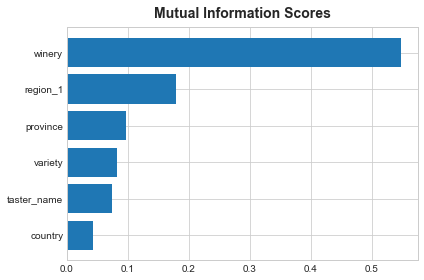

In [50]:
plot_mi_scores(mi_scores)

Like we can see from above diagram winery is the most relevant variable so further investigation is needed.

### Calculate Spearman correlation coefficient
Spearman's correlation determines the strength and direction of the monotonic relationship between two variables rather than the strength and direction of the linear relationship between two variables.

To be able to calculate spearman coefficient firstly we need to encode nominal variables to numerical ones with further encoders:
   - The **CountFrequencyEncoder()** replaces categories by either the count or the percentage of observations per category.For example in the variable colour, if 10 observations are blue, blue will be replaced by 10. Alternatively, if 10% of the observations are blue, blue will be replaced by 0.1.
   - The **DecisionTreeEncoder()** encodes categorical variables with predictions of a decision tree model. Each categorical feature is recoded by training a decision tree, typically of limited depth (2, 3 or 4) using that feature alone, and let the tree directly predict the target. The probabilistic predictions of this decision tree are used as the new values of the original categorical feature, that now is linearly (or at least monotonically) correlated with the target.

In [174]:
from feature_engine.encoding import CountFrequencyEncoder, DecisionTreeEncoder
from feature_engine import transformation as vt
import scipy.stats

encoders = [
            'CountFrequencyEncoder',
            'DecisionTreeEncoder'
            ]

feature_cols = ['country', 'variety', 'winery', 'province']

def calculate_statistics(df):
    """
    Calculate spearman's coefficient for different types of encoders.
    param df: pandas dataframe with filled missing values
    return: stats dict
    """
    features = df.loc[:, feature_cols]
    target = df["points"]
    
    encoder_dict = {}
    
    for en in encoders:
        if en == 'CountFrequencyEncoder':
            encoder = CountFrequencyEncoder(encoding_method='frequency', variables=feature_cols)
        
        elif en == 'DecisionTreeEncoder':
            encoder = DecisionTreeEncoder(variables=feature_cols, random_state=0)
        
        else:
            raise ValueError("{} encoder not recognised.".format(en))
        
        # fit the encoder
        encoder.fit(features, target)

        # transform the data
        features_not_null_encoded = encoder.transform(features).reset_index()
        target = target.reset_index().drop('index', axis=1)
        features_not_null_encoded = features_not_null_encoded.drop('index', axis=1)
        
        # calculate statistics
        stats_list = {key:[] for key in feature_cols}
        
        for col in feature_cols:
            # spearman's coefficient
            stats_list[col].append(scipy.stats.spearmanr(features_not_null_encoded[col], target)[0])
            # p-value
            stats_list[col].append(scipy.stats.spearmanr(features_not_null_encoded[col], target)[1])
        
        encoder_dict[en] = stats_list
        
    return encoder_dict

In [175]:
stats = calculate_statistics(df_mut_info)
stats

{'CountFrequencyEncoder': {'country': [0.06591098084695025,
   1.8208062661434385e-116],
  'variety': [0.09646270751237906, 9.647503472527121e-248],
  'winery': [0.15229393500762345, 0.0],
  'province': [0.09125739494420261, 7.683870064054998e-222]},
 'DecisionTreeEncoder': {'country': [0.15961457077402244, 0.0],
  'variety': [0.20084799542246104, 0.0],
  'winery': [0.14078121653375755, 0.0],
  'province': [0.18911317850502826, 0.0]}}

**Conclusion**

Results shows low correlation between all features and points target variable.
So all tested features will be removed from input data set. Accepted results will have spearman coefficient higher than abs(s_coeff_var_n) >= 0.5. Including one of this features in input dataset will add more noise in model. 

### Textual features

Description and title are textual features which we need to investgate. Firstly, we need to create base ML model based on most relevant (in this case description) feature. Than add new features like title and check perfomance in relation to base model. Before feed our model with input data, features need to be properly encoded. TF-IDF and Word Embedding are two of the most common methods in Natural Language Processing (NLP) to convert sentences to machine readable code. For comparison we will use TF-IDF representation and Random Forest decision tree based ensemble algorithm.

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

We are only interested on cross validation scores which will be calculated for 5 folds. Mean squared error 'mse' is used for evaluation metric.

Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors.

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [177]:
count_vect = CountVectorizer(max_features=100, stop_words='english')
df_count = count_vect.fit_transform(df_mut_info.description)
df_count.shape

(120883, 100)

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

In [178]:
tf_transformer = TfidfTransformer(use_idf=True).fit(df_count)
df_encode = tf_transformer.transform(df_count)
df_encode.shape

(120883, 100)

Normalize target variable.

In [179]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.array(df_mut_info['points']).reshape(-1, 1))
Y_train = scaler.transform(np.array(df_mut_info['points']).reshape(-1, 1))
Y_train = pd.DataFrame(Y_train, columns=['points'])
Y_train

,points
0,0.35
1,0.35
2,0.35
3,0.35
4,0.35
...,...
120878,0.50
120879,0.50
120880,0.50
120881,0.50


In [180]:
X_train = pd.DataFrame(df_encode.toarray())
print("Number of input rows of X_train is: {} ".format(X_train.shape[0]))
print("Number of input rows of Y_train is: {} ".format(Y_train.shape[0]))

Number of input rows of X_train is: 120883 
Number of input rows of Y_train is: 120883 


In [181]:
rf = RandomForestRegressor(n_jobs=-1)

In [182]:
base_score = np.mean(cross_val_score(rf, X_train, Y_train, cv=5))

In [183]:
base_score

0.3709616016002292

#### Title

In [187]:
df_mut_info['title'].head()

1        Quinta dos Avidagos 2011 Avidagos Red (Douro)
2        Rainstorm 2013 Pinot Gris (Willamette Valley)
3    St. Julian 2013 Reserve Late Harvest Riesling ...
4    Sweet Cheeks 2012 Vintner's Reserve Wild Child...
5    Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...
Name: title, dtype: object

Like we can see title feature contains year for every wine sample. This year can be extracted and new feature can be created.

In [188]:
df_mut_info['year'] = df_mut_info.title.str.extract('(\d+)')
df_mut_info['year']

1         2011
2         2013
3         2013
4         2012
5         2011
          ... 
129965    2013
129966    2004
129967    2013
129968    2012
129969    2012
Name: year, Length: 120883, dtype: object

In [189]:
df_mut_info['year'].isnull().sum()

3840

We need to convert year object type to integer and fill missing values with median value because if we will use mean value results will be like 2014.75 which is not what we want. We want round years.

In [190]:
df_year_not_null = df_mut_info['year'].dropna()
df_year_not_null = df_year_not_null.astype('int')
year_median = df_year_not_null.median()
df_mut_info['year'] = df_mut_info['year'].fillna(year_median).astype('int')
df_mut_info['year'].value_counts()

2011    15180
2013    15049
2014    14736
2012    14617
2010    11011
        ...  
1957        1
360         1
1961        1
428         1
128         1
Name: year, Length: 180, dtype: int64

#### Check correlation between year and points target variable

Some years are wrong specified for example 428 and we need to remove them.
Get reviews with year > 1900.

In [191]:
wine_years = df_mut_info.loc[df_mut_info['year'] > 1900]
wine_years.shape[0] / df_mut_info.shape[0]

0.9906190283166367

Calculate spearmans correlation factor

In [192]:
scipy.stats.spearmanr(wine_years['year'], wine_years['points'])[0]

0.07671341007851808

Based on calculated statistics we can conclude that given points and wine year are not correlated. So years will be removed from title text. Furthermore title will be concatenated with description feature and encodings will be defined on new input data.

In [193]:
df_mut_info = df_mut_info.drop('year', axis=1)

In [194]:
df_title = df_mut_info.title.str.replace('\d+', '')
df_title

1                 Quinta dos Avidagos  Avidagos Red (Douro)
2                 Rainstorm  Pinot Gris (Willamette Valley)
3         St. Julian  Reserve Late Harvest Riesling (Lak...
4         Sweet Cheeks  Vintner's Reserve Wild Child Blo...
5         Tandem  Ars In Vitro Tempranillo-Merlot (Navarra)
                                ...                        
129965    Dr. H. Thanisch (Erben Müller-Burggraef)  Brau...
129966                        Citation  Pinot Noir (Oregon)
129967       Domaine Gresser  Kritt Gewurztraminer (Alsace)
129968            Domaine Marcel Deiss  Pinot Gris (Alsace)
129969    Domaine Schoffit  Lieu-dit Harth Cuvée Carolin...
Name: title, Length: 120883, dtype: object

In [195]:
df_mut_info['title'] = df_mut_info['title'].str.replace('\d+', '')
df_mut_info['description'] = df_mut_info['description'].str.replace('\d+', '')
df_mut_info['desc_title'] = df_mut_info['description'] + df_mut_info['title']
df_mut_info['desc_title']

1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from , this com...
5         Blackberry and raspberry aromas show a typical...
                                ...                        
129965    Notes of honeysuckle and cantaloupe sweeten th...
129966    Citation is given as much as a decade of bottl...
129967    Well-drained gravel soil gives this wine its c...
129968    A dry style of Pinot Gris, this is crisp with ...
129969    Big, rich and off-dry, this is powered by inte...
Name: desc_title, Length: 120883, dtype: object

In [196]:
df_count = count_vect.fit_transform(df_mut_info.desc_title)
df_count.shape

(120883, 100)

In [197]:
df_encode = tf_transformer.transform(df_count)
df_encode.shape

(120883, 100)

In [198]:
X_train = pd.DataFrame(df_encode.toarray())
print("Number of input rows of X_train is: {} ".format(X_train.shape[0]))
print("Number of input rows of Y_train is: {} ".format(Y_train.shape[0]))

Number of input rows of X_train is: 120883 
Number of input rows of Y_train is: 120883 


In [199]:
title_score = np.mean(cross_val_score(rf, X_train, Y_train, cv=5))

In [200]:
title_score

0.39202932965874104

**Conclusion**

After adding title to input data we get worser results based on 'mse' evaluation metric, so we will drop title feature from input data.

## Final thoughts

Description feature has directly impact on target points variable, it's actually textual representation for points score given by tasters.
So only the last hypothesis is satisfied "Description is highly related with given score (points)".

Further step will be to encode description feature in TF-IDF or word embeding features and train regresion ML model.